# IMAGE CAPTIONING


In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import keras
from time import time
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras .models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add
import re
import string
import matplotlib.pyplot as plt
import os




Using TensorFlow backend.


In [2]:
# read text caption
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("../Desktop/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")

In [4]:
len(captions.split("\n"))

40461

In [5]:
captions = captions.split("\n")[:-1]

In [6]:
#dictionary to map each image with the list of captions it has
descripitions = {}
for x in captions:
    first, second = x.split("\t")
    img_name = first.split(".")[0]
    if descripitions.get(img_name) is None:
        descripitions[img_name] = []
    descripitions[img_name].append(second)
    

In [7]:
# clean of text
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re . sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)> 1]
    sentence = " ".join(sentence)
    return sentence

In [8]:
#clean all captions
for key,caption_list in descripitions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
        

In [9]:
with open ("descripitions_1.text","w")as f:
    f.write(str(descripitions))

In [10]:
descripitions = None
with open("descripitions_1.text","r")as f:
    descripitions = f.read()
    json_accept_str = descripitions.replace("'","\"")
    descripitions = json.loads(json_accept_str)

In [11]:
#vcab
vocab = set()
for key in descripitions.keys():
    [vocab.update(sentence.split())for sentence in descripitions[key]]

In [12]:
total_words = []
for key in descripitions.keys():
    [total_words.append(i)for des in descripitions[key] for i in des.split()]


In [13]:
len(total_words)

373837

In [14]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
sort_frg_cnt = sorted(frq_cnt.items(),reverse= True,key= lambda x :x[1])


In [15]:
threshold =10
sort_frg_cnt = [x for x in sort_frg_cnt if x[1] > threshold]
total_words = [x[0]for x in sort_frg_cnt]

In [16]:
len(total_words)

1845

### prepare train & test data

In [17]:
train_file_data = readTextFile("../Desktop/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("../Desktop/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [18]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [19]:
train_descriptions = {}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descripitions[img_id]:
        cap_to_append = "startseq "+cap+" endseq"
        train_descriptions[img_id].append(cap_to_append)

## image feature extraction

In [22]:
model = ResNet50(weights="imagenet",input_shape = (224,224,3))
model.summary()

W1022 16:06:29.875293  8276 deprecation_wrapper.py:119] From c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 16:06:30.105154  8276 deprecation_wrapper.py:119] From c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 16:06:30.190327  8276 deprecation_wrapper.py:119] From c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1022 16:06:30.353198  8276 deprecation_wrapper.py:119] From c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
model_new = Model(model.input,model.layers[-2].output)

In [24]:
def preproccess_img(img):
    img = image.load_img(img,target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

In [25]:
def encode_img (img):
    img = preproccess_img(img)
    feature_vec  = model_new.predict(img).reshape((-1,))
    return feature_vec

In [45]:
encoding_train = {}
start = time()
img_path = "../Desktop/Flickr_Data/Images/"


for ix,img_id in enumerate(train):
    new_img_path = img_path + img_id +".jpg"
    encoding_train[img_id]= encode_img(new_img_path)
    if ix % 1000==0:
        print("encoding in progress time step %d"%ix)
end_t = time()
print("total time taken:",end_t-start)

encoding in progress time step 0
encoding in progress time step 100
encoding in progress time step 200
encoding in progress time step 300
encoding in progress time step 400
encoding in progress time step 500
encoding in progress time step 600
encoding in progress time step 700
encoding in progress time step 800
encoding in progress time step 900
encoding in progress time step 1000
encoding in progress time step 1100
encoding in progress time step 1200
encoding in progress time step 1300
encoding in progress time step 1400
encoding in progress time step 1500
encoding in progress time step 1600
encoding in progress time step 1700
encoding in progress time step 1800
encoding in progress time step 1900
encoding in progress time step 2000
encoding in progress time step 2100
encoding in progress time step 2200
encoding in progress time step 2300
encoding in progress time step 2400
encoding in progress time step 2500
encoding in progress time step 2600
encoding in progress time step 2700
enco

In [ ]:
with open("encoding_train_feature.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
encoding_test = {}
start = time()
img_path = "../Desktop/Flickr_Data/Images/"


for ix,img_id in enumerate(test):
    new_img_path = img_path + img_id +".jpg"
    encoding_test[img_id]= encode_img(new_img_path)
    if ix % 100 ==0:
        print("encoding in progress time step %d"%ix)
end_t = time()
print("total time taken:",end_t-start)

In [26]:
with open("encoding_test_feature.pkl","wb") as f:
    pickle.dump(encoding_test,f)

NameError: name 'encoding_test' is not defined

In [ ]:
len(total_words)


In [ ]:
word_to_idx ={}
idx_to_word = {}


for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
#two special word start seqn & end seqn
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846
idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847


In [ ]:
vocab_size = len(word_to_idx)+1


In [ ]:
vocab_size

In [ ]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
    

## data loader

In [29]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n +=1 
            
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word]for word in desc.split()if word in word_to_idx]
                for i in range (1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    
                    # 0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value = 0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0
                

### word embeddings


In [30]:
f = open("../Desktop/glove.6B.50d.txt",encoding='utf8')

In [31]:
embedding_index ={}
for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = 'float')
    embedding_index[word] = word_embedding
f.close()

In [32]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None :
            matrix [idx] = embedding_vector
    return matrix

In [33]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

NameError: name 'vocab_size' is not defined

## image captioning model architecture

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation = 'relu')(inp_img1)

In [ ]:
#caption as input
input_captions = Input(shape=(max_len,))
input_cap1 = Embedding(input_dim = vocab_size, mask_zero=True,output_dim = 50)(input_captions)
input_cap2 = Dropout(.3)(input_cap1)
input_cap3 = LSTM(256)(input_cap2)

In [ ]:
decoder1 = add([inp_img2,input_cap3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#combined model
model = Model(inputs =[input_img_features,input_captions],outputs = outputs)


In [ ]:
model.summary()

In [ ]:
# improtant then embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('C:/Users/Dell/Desktop/model_weights/model_'+str(i)+'.h5')

In [36]:
model = load_model("C:/Users/Dell/Desktop/model_weights/model_19.h5")

W1014 00:14:42.539870 14472 deprecation.py:506] From c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1014 00:14:43.068761 14472 deprecation.py:323] From c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:2974: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1014 00:14:43.944292 14472 deprecation_wrapper.py:119] From c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Pleas

In [37]:
from pickle import load
with open("C:/Users/Dell/Desktop/encoding_test_feature.pkl","rb") as f:
    encoding_test = load(f)

# predictions

In [38]:
def predict_caption(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w]for w in in_text.split()if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen= max_len,padding="post")
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += ' '+ word
        if word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

# load the image from test data

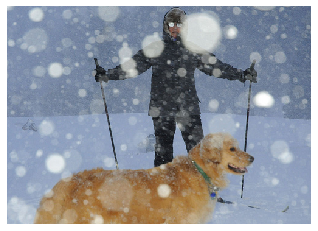

avish : two children putting on tire


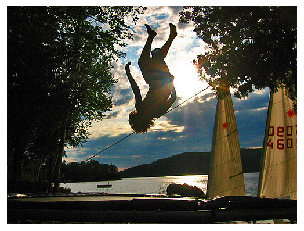

avish : snowboarder jumps off ramp


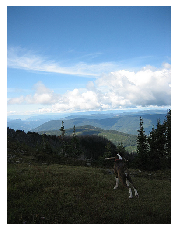

avish : two people are walking through the desert


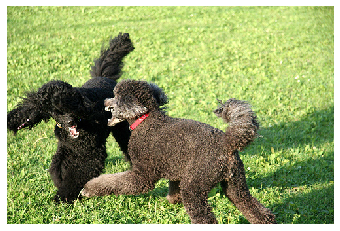

avish : black dog running through field


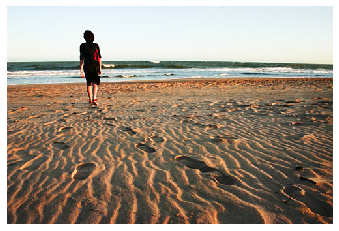

avish : young boy running along the beach


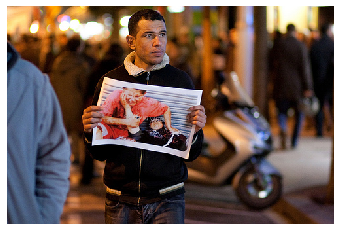

avish : man in red shirt and hat is standing in front of crowd


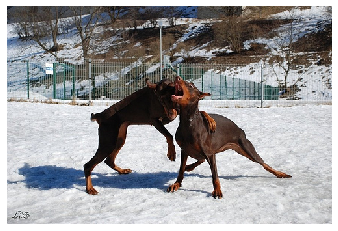

avish : two dogs are playing in the dirt


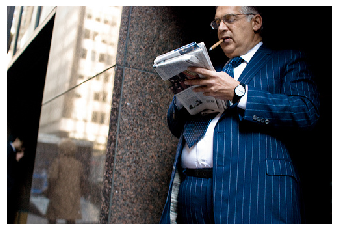

avish : man in black shirt and black shirt reads book


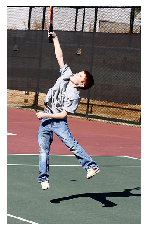

avish : boy swings on swing


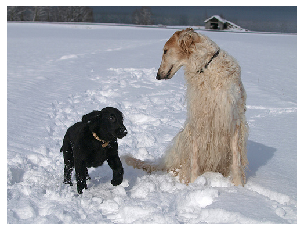

avish : two dogs are playing in the snow


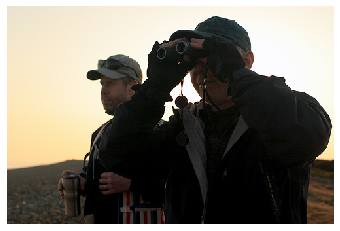

avish : man with guitar wears and tie of hand


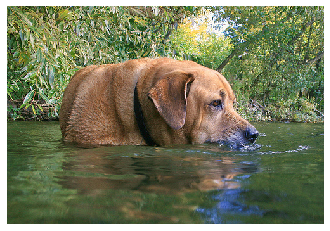

avish : dog is swimming in the grass


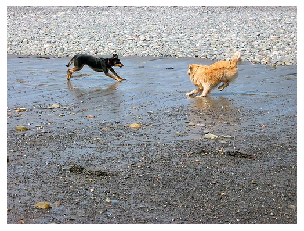

avish : two dogs are running on the beach


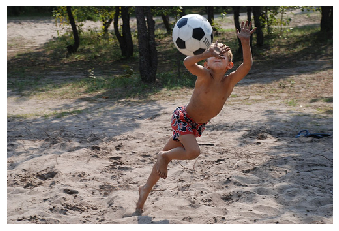

avish : boy in shorts and blue shorts is holding surfboard


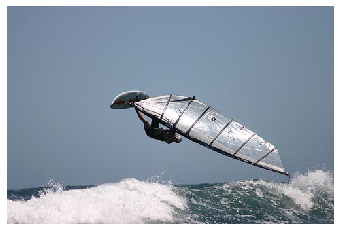

avish : man in midair harness in the ocean


In [43]:
for i in range (15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    image_name = all_img_names[idx]
    photo_2048 = encoding_test[image_name].reshape((1,2048))
    
    i = plt.imread("C:/Users/Dell/Desktop/Flickr_Data/Images/"+image_name+".jpg")
    caption = predict_caption(photo_2048)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    print("avish : "+caption)

In [117]:
pad_sequences?


6000

In [48]:
16%4

0

In [53]:
var = input()
out = eval(var)
out

print(2+3)
5


In [57]:
i = '12'
print(i[::-1])

21
